In [1]:
!pip install tensorflow

In [2]:
!pip install tqdm

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph, Source
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import PIL
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [1]:
version = 12
folder = f"/Users/yaeerk/Documents/NAYA/FinalProject/QRcode{version}"

dataset_max_size = 30000

sub_folders = ("benign", "malware", "defacement", "phishing")
cnt_folders = (dataset_max_size * 3, dataset_max_size, dataset_max_size, dataset_max_size)               
cls_folders = (0, 1, 1, 1)
new_labels = ("benign", "malicious")

random_state = 43021
train_size = 0.8
epochs = 25
batch_size = 128
steps_per_epoch = dataset_max_size // batch_size

filename = f"{dataset_max_size}-{train_size}-{epochs}-{steps_per_epoch}-{version}"
save_path = "/tmp/qrcode/"

In [5]:
if(version == 4):
    image_size = (33, 33)
elif(version == 5):
    image_size = (37, 37)
elif(version == 6):
    image_size = (41, 41)
elif(version == 12):
    image_size = (65, 65)
else:
    image_size = (36, 36)

In [6]:
#https://www.kaggle.com/datasets/samahsadiq/benign-and-malicious-qr-codes

#load the dataset

try:

    #read the images
    with open(save_path + 'binary-qr-image-' + str(dataset_max_size), 'rb') as f:
        X = np.load(f)

    #read the labels
    with open(save_path + 'binary-qr-label-' + str(dataset_max_size), 'rb') as f:
        y = np.load(f)

    print(f"dataset was loaded")

except:
        
    X, y = [], []
        
    for p, sub_folder in enumerate(sub_folders):
                  
        X_subfolder, y_subfolder = [], []
            
        path = folder + "/" + sub_folder
        image_filenames = [filename for filename in os.listdir(path) if("png" in filename)]

        if(len(image_filenames) > cnt_folders[p]):        
            image_filenames = image_filenames[:cnt_folders[p]]

        for image_filename in tqdm(image_filenames, desc = "Loading " +  sub_folder, ncols = 110):

            try:
                m = Image.open(path + "/" + image_filename)

                #resize to predefined size
                m = m.resize(image_size, resample = PIL.Image.BICUBIC)

                #convert to gray scale
                m = ImageOps.grayscale(m)

                #convert to numpy array and do not rescale, save it in byte (smaller size on disk)
                n = np.array(m.getdata()).reshape(image_size[0], image_size[1], 1) / 255.0

                #append to datasets
                X_subfolder.append(n)                    
                y_subfolder.append(cls_folders[p])

            except:
                print(f"count not load: {image_filenames}")

        #rescale
        X.extend(X_subfolder)
        y.extend(y_subfolder)

    X = np.array(X)
    y = np.array(y)
              
    try:
        #save the images
        with open(save_path + 'binary-qr-image-' + str(dataset_max_size), 'wb') as f:
            np.save(f, X)

        #save the labels
        with open(save_path + 'binary-qr-label-' + str(dataset_max_size), 'wb') as f:
            np.save(f, y)

    except:
        print("unable to save images & labels")

Loading phishing: 100%|████████████████████████████████████████████████| 30000/30000 [00:43<00:00, 691.51it/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = random_state)

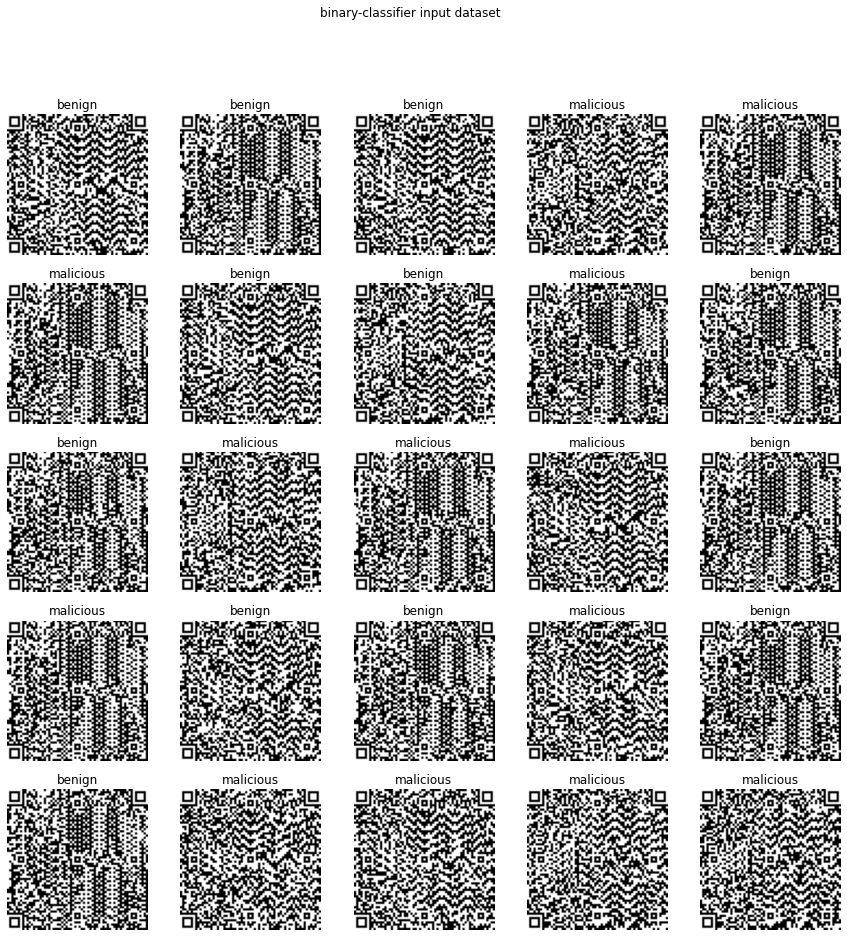

In [19]:
#visualize the input data
fig = plt.figure(figsize = (15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i], cmap = 'binary')
    plt.title(new_labels[y_test[i]])
    plt.axis("off")
    
fig.suptitle('binary-classifier input dataset')
plt.savefig(save_path + "binary-classifier-" + filename + "-visualization.png")
plt.show()

In [9]:
#typical categobinaryrial classifier
binaryclassifier = tf.keras.Sequential([

    tf.keras.layers.Input(shape = (image_size[0], image_size[1], 1)),

    tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "same"),

    tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "same"),

    tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "same"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation = "relu"),
    #tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation = "sigmoid")
])

binaryclassifier.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"])

binaryclassifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 648)               0

In [10]:
history = binaryclassifier.fit(
    x = X_train, 
    y = y_train,
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch, 
    
    validation_data = (X_test, y_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)])

Epoch 1/25
234/234 [==============================] - 174s 737ms/step - loss: 0.4279 - binary_accuracy: 0.8097 - val_loss: 0.2936 - val_binary_accuracy: 0.8741
Epoch 2/25
234/234 [==============================] - 173s 741ms/step - loss: 0.2657 - binary_accuracy: 0.8890 - val_loss: 0.2482 - val_binary_accuracy: 0.9000
Epoch 3/25
234/234 [==============================] - 172s 734ms/step - loss: 0.2321 - binary_accuracy: 0.9052 - val_loss: 0.2323 - val_binary_accuracy: 0.9081
Epoch 4/25
234/234 [==============================] - 170s 727ms/step - loss: 0.2142 - binary_accuracy: 0.9147 - val_loss: 0.2148 - val_binary_accuracy: 0.9169
Epoch 5/25
234/234 [==============================] - 170s 727ms/step - loss: 0.2017 - binary_accuracy: 0.9210 - val_loss: 0.2202 - val_binary_accuracy: 0.9089
Epoch 6/25
234/234 [==============================] - 170s 729ms/step - loss: 0.1915 - binary_accuracy: 0.9253 - val_loss: 0.2048 - val_binary_accuracy: 0.9201
Epoch 7/25
234/234 [====================

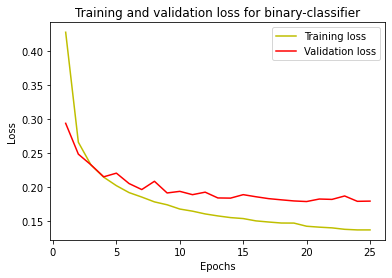

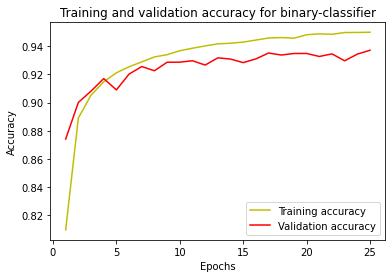

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(loss) + 1)
plt.plot(epoch, loss, 'y', label = 'Training loss')
plt.plot(epoch, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss for binary-classifier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_path + "binary-classifier-" + filename + "-loss_vs_epoch.png")
plt.show()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epoch, acc, 'y', label = 'Training accuracy')
plt.plot(epoch, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy for binary-classifier')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_path + "binary-classifier-" + filename + "-accuracy_vs_epoch.png")
plt.show()

In [12]:
#get actual metrics of train data
score_train = binaryclassifier.evaluate(X_train, y_train)

#get actual metrics of test data
score_test = binaryclassifier.evaluate(X_test, y_test)

1125/1125 [==============================] - 13s 12ms/step - loss: 0.1789 - binary_accuracy: 0.9370


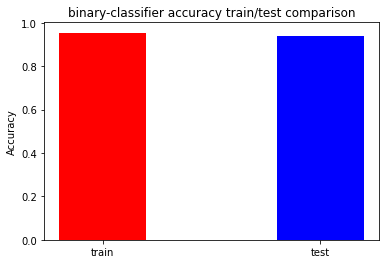

In [17]:
plt.bar(["train", "test"], 
        [score_train[1], score_test[1]],
        color =['red', 'blue'], width = 0.4)
 
plt.ylabel("Accuracy")
plt.title("binary-classifier accuracy train/test comparison")
plt.savefig(save_path + "binary-classifier-" + filename + "-train-test-accuracy.png")
plt.show()

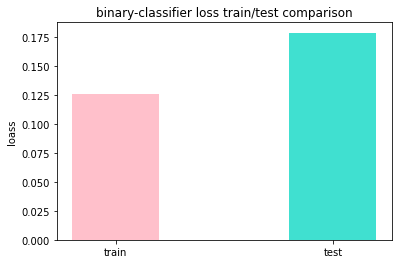

In [18]:
plt.bar(["train", "test"], 
        [score_train[0], score_test[0]],
        color =['pink', 'turquoise'], width = 0.4)
 
plt.ylabel("loass")
plt.title("binary-classifier loss train/test comparison")
plt.savefig(save_path + "binary-classifier-" + filename + "-train-test-loss.png")
plt.show()

In [15]:
 binaryclassifier.save(save_path + "binary-classifier-" + filename)

INFO:tensorflow:Assets written to: /tmp/qrcode/binary-classifier-30000-0.8-25-234-12/assets
